In [ ]:
import os
import random
random.seed(0)
!unzip './dataset/pneumothoraxdataset.zip'

In [ ]:
import os
import cv2
import scipy as sp
import numpy as np
import pydicom
from PIL import Image
import pandas as pd
from pydicom.pixel_data_handlers.util import apply_color_lut
from glob import glob
import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib import patches as patches

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D,Add
from tensorflow.keras.layers import MaxPooling2D,ZeroPadding2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow_io as tfio
%load_ext tensorboard

from sklearn.metrics import classification_report, confusion_matrix

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
train = glob('/../train/*')
mask = glob('/../masks/*')
test = glob('/../test/*')
len(train), len(mask), len(test)

(12047, 12047, 3205)

In [ ]:
all_mask_fn = glob.glob('/../masks/*')
mask_df = pd.DataFrame()
mask_df['file_names'] = all_mask_fn
mask_df['mask_percentage'] = 0
mask_df.set_index('file_names',inplace=True)
for fn in all_mask_fn:
    mask_df.loc[fn,'mask_percentage'] = np.array(Image.open(fn)).sum()/(256*256*255) #255 is bcz img range is 255
    
mask_df.reset_index(inplace=True)
mask_df['labels'] = 0
mask_df.loc[mask_df.mask_percentage>0,'labels'] = 1
#sns.distplot(mask_df.mask_percentage.values)

In [ ]:
labels=[]
for idx in tqdm.tqdm_notebook(range(12047)):
  tmp=np.array(Image.open(all_mask_fn[idx])).sum()/(256*256*255)
  if tmp > 0:
    labels.append(1)
  else:
    labels.append(0)

In [ ]:
final = pd.DataFrame({'path': all_train_fn, 'labels': labels})

X = np.array(all_train_fn)
y = np.array(labels)

final = pd.DataFrame({'path': all_train_fn, 'labels': labels})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

In [ ]:
size = 256

import cv2
#Input Data Pipeline.

def train_data_generator(images, labels, batch_size):
    
    def parse_function(filename, label):
      image_string = tf.io.read_file(filename)
      image = tf.image.decode_png(image_string, channels=3)
      image = tf.image.resize(image, [size, size])
      image = image/255.0

      image = tf.image.random_flip_left_right(image)
      image = tf.image.random_flip_up_down(image)
      image = tf.image.random_brightness(image, 0.3)     
      y = tf.one_hot(tf.cast(label, tf.uint8), 2)  
      return image, y
      
    ##creating a dataset from tensorslices
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=4)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

#Input Data Pipeline.

def test_data_generator(images, labels, batch_size):
    
    def parse_function(filename, label):
      image_string = tf.io.read_file(filename)
      image = tf.image.decode_png(image_string, channels=3)
      image = tf.image.resize(image, [size, size])
      image = image/255.0
      y = tf.one_hot(tf.cast(label, tf.uint8), 2)  
      return image, y
      
    ##creating a dataset from tensorslices
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=4)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, load_model

def get_chexnet_model():
    input_shape = (256, 256, 3)
    img_input = Input(shape=input_shape)
    base_weights = 'imagenet'

    # create the base pre-trained model
    base_model = DenseNet121(
        include_top=False,
        input_tensor=img_input,
        input_shape=input_shape,
        weights=base_weights,
        pooling='avg'
    )

    x = base_model.output
    # add a logistic layer -- let's say we have 14 classes
    predictions = Dense(
        14,
        activation='sigmoid',
        name='predictions')(x)

    # this is the model we will use
    model = Model(
        inputs=img_input,
        outputs=predictions,
    )

    # load chexnet weights
    model.load_weights('./models/best_weights.h5')

    # return model
    return base_model, model

In [ ]:
tf.random.set_seed(1234)
base, model = get_chexnet_model()
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(model.layers[-2].output)
x = Dense(2, activation='softmax', kernel_initializer='he_normal')(x)

final_model =  Model(model.input, x)
final_model.summary()

Model: "functional_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_16 (ZeroPadding2 (None, 262, 262, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d_16[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________

In [ ]:
Train_pipeline = train_data_generator(X_train, y_train, batch_size=16)
Test_pipeline  = test_data_generator(X_test, y_test,batch_size=16)
Train_pipeline

<PrefetchDataset shapes: ((16, 256, 256, 3), (16, 2)), types: (tf.float32, tf.float32)>

In [ ]:
mask_df['image'] = [fn.replace('/masks/','/train/') for fn in mask_df.loc[:,'file_names'].values]
tmp_df = mask_df[mask_df.labels==1]
tmp_df['image'] = [fn.replace('/masks/','/train/') for fn in tmp_df.loc[:,'file_names'].values]
tmp_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,file_names,mask_percentage,labels,image
12048,/content/masks/1.2.276.0.7230010.3.1.4.8323329...,0.005577,1,/content/train/1.2.276.0.7230010.3.1.4.8323329...
12049,/content/masks/1.2.276.0.7230010.3.1.4.8323329...,0.071230,1,/content/train/1.2.276.0.7230010.3.1.4.8323329...
12051,/content/masks/1.2.276.0.7230010.3.1.4.8323329...,0.006253,1,/content/train/1.2.276.0.7230010.3.1.4.8323329...
12064,/content/masks/1.2.276.0.7230010.3.1.4.8323329...,0.051229,1,/content/train/1.2.276.0.7230010.3.1.4.8323329...
12065,/content/masks/1.2.276.0.7230010.3.1.4.8323329...,0.008172,1,/content/train/1.2.276.0.7230010.3.1.4.8323329...


In [ ]:
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC(), 'accuracy'])
final_model.fit_generator(generator=Train_pipeline, epochs=10, validation_data=Test_pipeline)

Epoch 1/10
602/602 [==============================] - 311s 517ms/step - loss: 0.4012 - auc_1: 0.9024 - accuracy: 0.8219 - val_loss: 0.5873 - val_auc_1: 0.9060 - val_accuracy: 0.7800
Epoch 2/10
602/602 [==============================] - 310s 514ms/step - loss: 0.3419 - auc_1: 0.9276 - accuracy: 0.8495 - val_loss: 0.3613 - val_auc_1: 0.9200 - val_accuracy: 0.8404
Epoch 3/10
602/602 [==============================] - 309s 513ms/step - loss: 0.3212 - auc_1: 0.9367 - accuracy: 0.8574 - val_loss: 0.3314 - val_auc_1: 0.9324 - val_accuracy: 0.8487
Epoch 4/10
602/602 [==============================] - 309s 514ms/step - loss: 0.3041 - auc_1: 0.9435 - accuracy: 0.8651 - val_loss: 0.4467 - val_auc_1: 0.9208 - val_accuracy: 0.8313
Epoch 5/10
602/602 [==============================] - 309s 513ms/step - loss: 0.2915 - auc_1: 0.9483 - accuracy: 0.8753 - val_loss: 0.3828 - val_auc_1: 0.9294 - val_accuracy: 0.8446
Epoch 6/10
602/602 [==============================] - 310s 514ms/step - loss: 0.2677 - auc

# Class Activation Map(CAM) :

In [ ]:
def Class_Activation_Map():
  id = tmp_df.index[np.random.randint(len(tmp_df.index))]
  img = cv2.imread(tmp_df.loc[id, 'image'])
  img = img/255.0
  img = tf.expand_dims(img, axis=0)
  argmax = np.argmax(final_model.predict(img, steps=1))

  outputs = []
  for idx, layer in enumerate(final_model.layers):
      if idx == 426:
        keras_function = K.function([final_model.input], [layer.output])
        outputs.append(keras_function([img, 1]))

  fmap = outputs[0][0][0]
  w = final_model.layers[-1].get_weights()[0][:, argmax]

  heat = sp.ndimage.zoom(fmap.dot(w), (32,32), order=1)
  print(id,"Predicted: ",argmax)
  plt.imshow(img[0])
  plt.imshow(heat, cmap='jet', alpha=0.5)
  plt.show()

18562 Predicted:  1


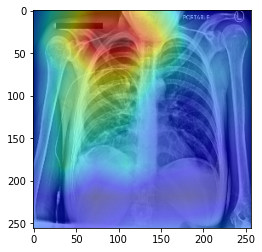

In [ ]:
Class_Activation_Map()

18662 Predicted:  1


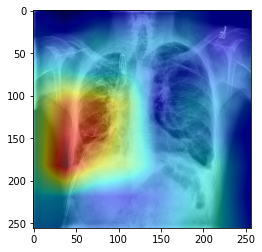

In [ ]:
Class_Activation_Map()

18169 Predicted:  1


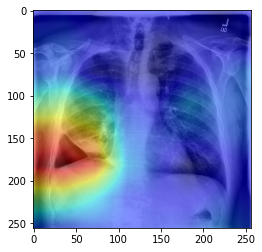

In [ ]:
Class_Activation_Map()

22546 Predicted:  1


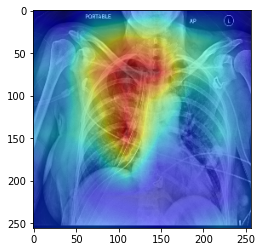

In [ ]:
Class_Activation_Map()

17717 Predicted:  1


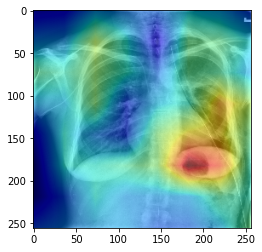

In [ ]:
Class_Activation_Map()

In [ ]:
_ = final_model.evaluate(Train_pipeline)
_ = final_model.evaluate(Test_pipeline)

37/37 [==============================] - 5s 132ms/step - loss: 0.4988 - auc: 0.9214 - accuracy: 0.8438


In [ ]:
pred = []
for idx in tqdm.tqdm_notebook(range(len(X_test))):
  img = cv2.imread(X_test[idx])
  img = img/255.0
  pre = final_model.predict(tf.expand_dims(img, axis=0))
  pred.append(np.argmax(pre))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1871
           1       0.70      0.53      0.61       539

    accuracy                           0.84      2410
   macro avg       0.79      0.73      0.75      2410
weighted avg       0.84      0.84      0.84      2410

[[1749  122]
 [ 252  287]]


In [ ]:
final_model.save_weights('/content/drive/My Drive/Case-Study 1/classifier.hdf5')